In [2]:
import pandas as pd
import numpy as np

precip = pd.read_csv("basin_averaged_climate_data/basin_total_precipitation.csv", index_col=0)
stream = pd.read_csv("combined_streamflow_cleaned.csv", index_col=0)

# Ensure they align
assert precip.shape[0] == stream.shape[0]


In [5]:
station_id = "05AH041"

precip_series = precip[station_id].values
stream_series = stream[station_id].values

In [6]:
N = 365  # lookback window

def create_dataset(X, y, N):
    X_out, y_out = [], []
    for i in range(len(X) - N - 1):
        X_out.append(X[i:i+N])
        y_out.append(y[i+N])
    return np.array(X_out), np.array(y_out)

X, y = create_dataset(precip_series, stream_series, N)

# reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)


In [8]:
split1 = int(0.7 * len(X))
split2 = int(0.9 * len(X))

X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

In [9]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

# reshape to 2D (samples, features)
X_train_2d = X_train.reshape(-1, 1)
X_val_2d   = X_val.reshape(-1, 1)
X_test_2d  = X_test.reshape(-1, 1)

X_train_scaled = scaler_x.fit_transform(X_train_2d).reshape(X_train.shape)
X_val_scaled   = scaler_x.transform(X_val_2d).reshape(X_val.shape)
X_test_scaled  = scaler_x.transform(X_test_2d).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1))


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.LSTM(80, return_sequences=False, input_shape=(N, 1)),
    layers.Dropout(0.1),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80)             │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,321 (102.82 KB)

 Trainable params: 26,321 (102.82 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=32
)


Epoch 1/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - loss: 0.8195 - val_loss: 3.7603
Epoch 2/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - loss: 1.0346 - val_loss: 3.7658
Epoch 3/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 1.0042 - val_loss: 3.7665
Epoch 4/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - loss: 0.8926 - val_loss: 3.7761
Epoch 5/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - loss: 1.1099 - val_loss: 3.8176
Epoch 6/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 0.9347 - val_loss: 3.7670
Epoch 7/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - loss: 0.8970 - val_loss: 3.7780
Epoch 8/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - loss: 0.7918 - val_loss: 3.7734
Epoch 9/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - loss: 0.8520 - val_loss: 3.7671
Epoch 10/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 0.7583 - val_loss: 3.7318
Epoch 11/20
336/336 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - loss: 0.9304 - val_loss: 3.7437
Epoch 12/20
336/336

In [16]:
def nse(observed, simulated):
    """
    Nash–Sutcliffe Efficiency (NSE)
    """
    return 1 - np.sum((observed - simulated)**2) / np.sum((observed - np.mean(observed))**2)

# Predict validation period
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

# True values already in y_val (unscaled)
y_val_true = y_val

val_nse = nse(y_val_true, y_val_pred.flatten())
print("Validation NSE:", val_nse)

96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step
Validation NSE: 0.0236019051747256


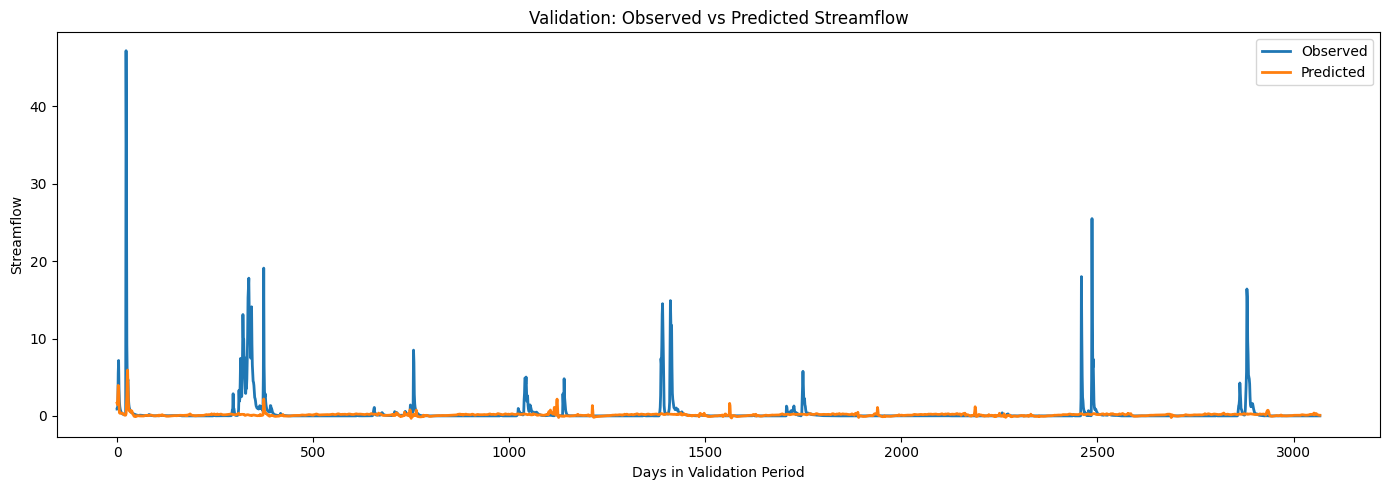

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_val_true, label="Observed", linewidth=2)
plt.plot(y_val_pred, label="Predicted", linewidth=2)
plt.title("Validation: Observed vs Predicted Streamflow")
plt.xlabel("Days in Validation Period")
plt.ylabel("Streamflow")
plt.legend()
plt.tight_layout()
plt.show()


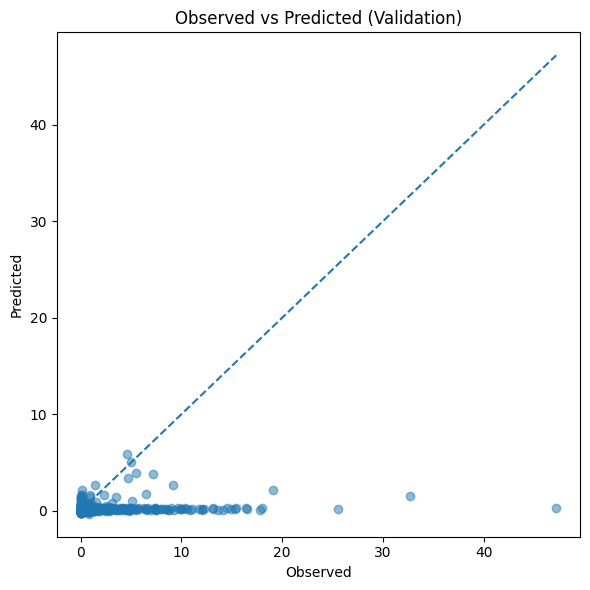

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
plt.plot([min(y_val_true), max(y_val_true)],
         [min(y_val_true), max(y_val_true)], 
         linestyle="--")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted (Validation)")
plt.tight_layout()
plt.show()
